In [1]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [2]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, headers = {"Accept-Language": "en-US, en;q=0.5"}) # randomHeader

In [3]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [4]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [5]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [6]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [7]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  16,074  2,751  13,128  195',
 'FCT  4,525  3,172  1,307  46',
 'Oyo  2,890  1,436  1,423  31',
 'Edo  2,399  178  2,121  100',
 'Rivers  1,972  196  1,721  55',
 'Kano  1,643  276  1,313  54',
 'Kaduna  1,628  207  1,409  12',
 'Delta  1,613  139  1,430  44',
 'Plateau  1,584  899  662  23',
 'Ogun  1,497  210  1,263  24',
 'Ondo  1,324  529  767  28',
 'Enugu  914  395  500  19',
 'Ebonyi  888  69  793  26',
 'Kwara  882  311  549  22',
 'Katsina  746  265  457  24',
 'Borno  690  78  576  36',
 'Abia  663  141  517  5',
 'Osun  652  298  341  13',
 'Gombe  635  50  562  23',
 'Bauchi  578  34  530  14',
 'Imo  485  314  161  10',
 'Benue  430  282  139  9',
 'Nasarawa  371  140  223  8',
 'Bayelsa  346  14  311  21',
 'Jigawa  322  3  308  11',
 'Akwa Ibom  235  30  197   8',
 'Niger  226  49  165  12',
 'Ekiti  193  112  79  2',
 'Adamawa  185  83  90  12',
 'Anambra  156  19  119  18',
 'Sokoto  154  0  138  16',
 'Kebbi  90  0  82  8',
 'Taraba  78  19  55  4',
 'Zamfara 

In [8]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '16,074', '2,751', '13,128', '195'],
 ['FCT', '4,525', '3,172', '1,307', '46'],
 ['Oyo', '2,890', '1,436', '1,423', '31'],
 ['Edo', '2,399', '178', '2,121', '100'],
 ['Rivers', '1,972', '196', '1,721', '55'],
 ['Kano', '1,643', '276', '1,313', '54'],
 ['Kaduna', '1,628', '207', '1,409', '12'],
 ['Delta', '1,613', '139', '1,430', '44'],
 ['Plateau', '1,584', '899', '662', '23'],
 ['Ogun', '1,497', '210', '1,263', '24'],
 ['Ondo', '1,324', '529', '767', '28'],
 ['Enugu', '914', '395', '500', '19'],
 ['Ebonyi', '888', '69', '793', '26'],
 ['Kwara', '882', '311', '549', '22'],
 ['Katsina', '746', '265', '457', '24'],
 ['Borno', '690', '78', '576', '36'],
 ['Abia', '663', '141', '517', '5'],
 ['Osun', '652', '298', '341', '13'],
 ['Gombe', '635', '50', '562', '23'],
 ['Bauchi', '578', '34', '530', '14'],
 ['Imo', '485', '314', '161', '10'],
 ['Benue', '430', '282', '139', '9'],
 ['Nasarawa', '371', '140', '223', '8'],
 ['Bayelsa', '346', '14', '311', '21'],
 ['Jigawa', '322', '3'

In [9]:
# Locate index position of Akwa Ibom
def get_index(strings, substr):
    for idx, string in enumerate(strings):
        if substr in string:
            break
    return idx

In [10]:
idx = get_index(table_rows, 'Akwa')

In [11]:
# Join 'Akwa' and 'Ibom'
del table_rows[idx][1]
table_rows[idx][0] = 'Akwa Ibom'
table_rows

[['Lagos', '16,074', '2,751', '13,128', '195'],
 ['FCT', '4,525', '3,172', '1,307', '46'],
 ['Oyo', '2,890', '1,436', '1,423', '31'],
 ['Edo', '2,399', '178', '2,121', '100'],
 ['Rivers', '1,972', '196', '1,721', '55'],
 ['Kano', '1,643', '276', '1,313', '54'],
 ['Kaduna', '1,628', '207', '1,409', '12'],
 ['Delta', '1,613', '139', '1,430', '44'],
 ['Plateau', '1,584', '899', '662', '23'],
 ['Ogun', '1,497', '210', '1,263', '24'],
 ['Ondo', '1,324', '529', '767', '28'],
 ['Enugu', '914', '395', '500', '19'],
 ['Ebonyi', '888', '69', '793', '26'],
 ['Kwara', '882', '311', '549', '22'],
 ['Katsina', '746', '265', '457', '24'],
 ['Borno', '690', '78', '576', '36'],
 ['Abia', '663', '141', '517', '5'],
 ['Osun', '652', '298', '341', '13'],
 ['Gombe', '635', '50', '562', '23'],
 ['Bauchi', '578', '34', '530', '14'],
 ['Imo', '485', '314', '161', '10'],
 ['Benue', '430', '282', '139', '9'],
 ['Nasarawa', '371', '140', '223', '8'],
 ['Bayelsa', '346', '14', '311', '21'],
 ['Jigawa', '322', '3'

In [12]:
idx = get_index(table_rows, 'Cross')

In [13]:
# Join 'Cross' and 'River'
del table_rows[idx][1]
table_rows[idx][0] = 'Cross River'
table_rows

[['Lagos', '16,074', '2,751', '13,128', '195'],
 ['FCT', '4,525', '3,172', '1,307', '46'],
 ['Oyo', '2,890', '1,436', '1,423', '31'],
 ['Edo', '2,399', '178', '2,121', '100'],
 ['Rivers', '1,972', '196', '1,721', '55'],
 ['Kano', '1,643', '276', '1,313', '54'],
 ['Kaduna', '1,628', '207', '1,409', '12'],
 ['Delta', '1,613', '139', '1,430', '44'],
 ['Plateau', '1,584', '899', '662', '23'],
 ['Ogun', '1,497', '210', '1,263', '24'],
 ['Ondo', '1,324', '529', '767', '28'],
 ['Enugu', '914', '395', '500', '19'],
 ['Ebonyi', '888', '69', '793', '26'],
 ['Kwara', '882', '311', '549', '22'],
 ['Katsina', '746', '265', '457', '24'],
 ['Borno', '690', '78', '576', '36'],
 ['Abia', '663', '141', '517', '5'],
 ['Osun', '652', '298', '341', '13'],
 ['Gombe', '635', '50', '562', '23'],
 ['Bauchi', '578', '34', '530', '14'],
 ['Imo', '485', '314', '161', '10'],
 ['Benue', '430', '282', '139', '9'],
 ['Nasarawa', '371', '140', '223', '8'],
 ['Bayelsa', '346', '14', '311', '21'],
 ['Jigawa', '322', '3'

In [14]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"16,074","2,751","13,128",195
1,FCT,"4,525","3,172","1,307",46
2,Oyo,"2,890","1,436","1,423",31
3,Edo,"2,399",178,"2,121",100
4,Rivers,"1,972",196,"1,721",55


In [15]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"16,074","2,751","13,128",195
1,FCT,"4,525","3,172","1,307",46
2,Oyo,"2,890","1,436","1,423",31
3,Edo,"2,399",178,"2,121",100
4,Rivers,"1,972",196,"1,721",55


In [16]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [17]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [18]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [19]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [20]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [21]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,16074,2751,13128,195
1,Federal Capital Territory,4525,3172,1307,46
2,Oyo,2890,1436,1423,31


In [22]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [23]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [24]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [25]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [26]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [27]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [28]:
shapefile.columns = ['States', 'geometry']

In [29]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [30]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [31]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (37, 6))

In [32]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",663,141,517,5
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",185,83,90,12


In [33]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'label':'Counts', 'fraction':0.036, 'pad':0, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue.lower()), dpi=150)

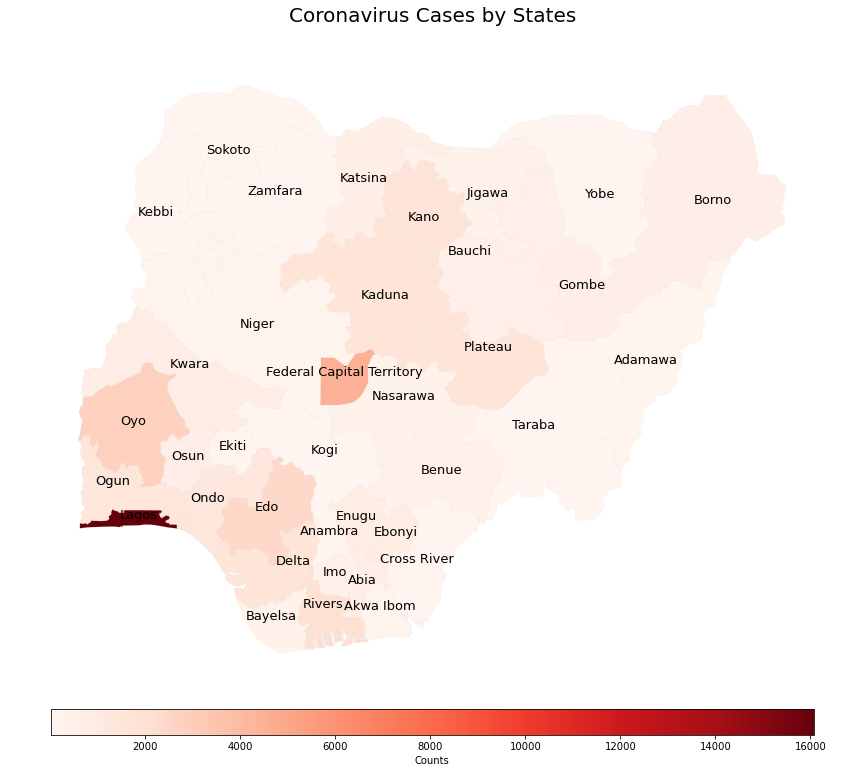

In [34]:
# Plot geomap for cases
visual(data, 'Cases', 'Reds')

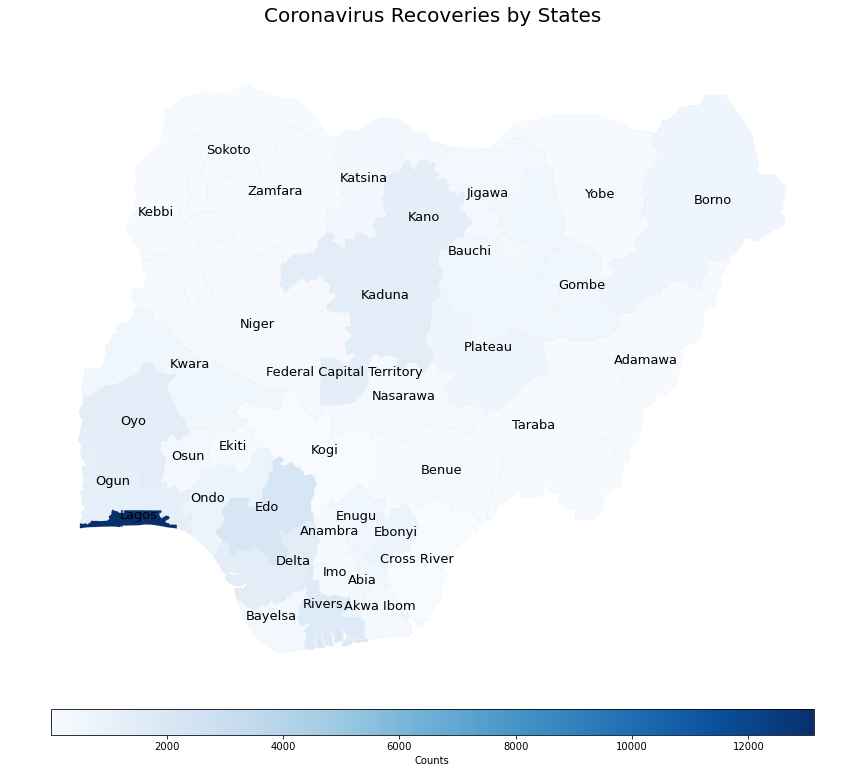

In [35]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues')

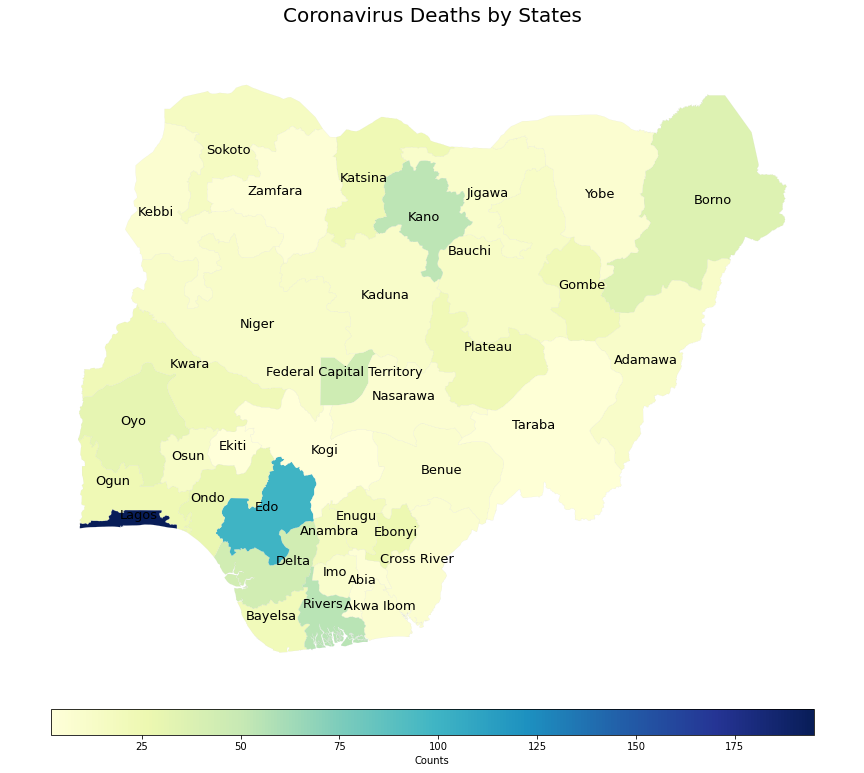

In [36]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [37]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [38]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [39]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [40]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [41]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [42]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [43]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [44]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [45]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [46]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [47]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [48]:
time_series = time_series.asfreq('D', method = 'ffill')

In [49]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [50]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [51]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

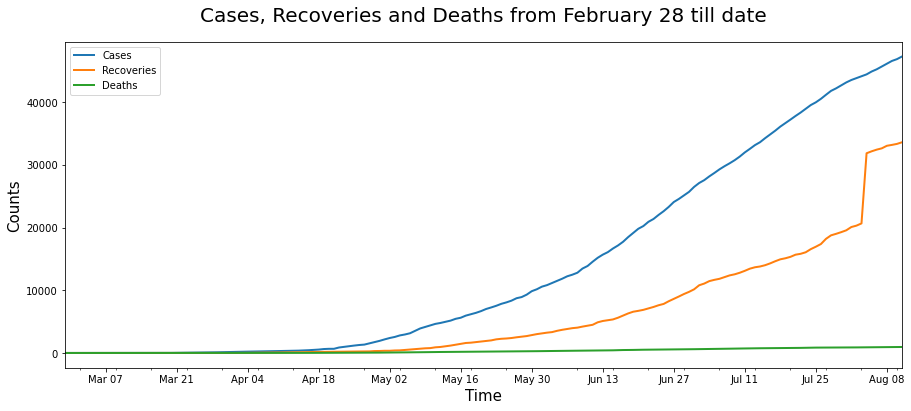

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
time_series.plot(linewidth=2, ax=ax)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png', dpi=150)

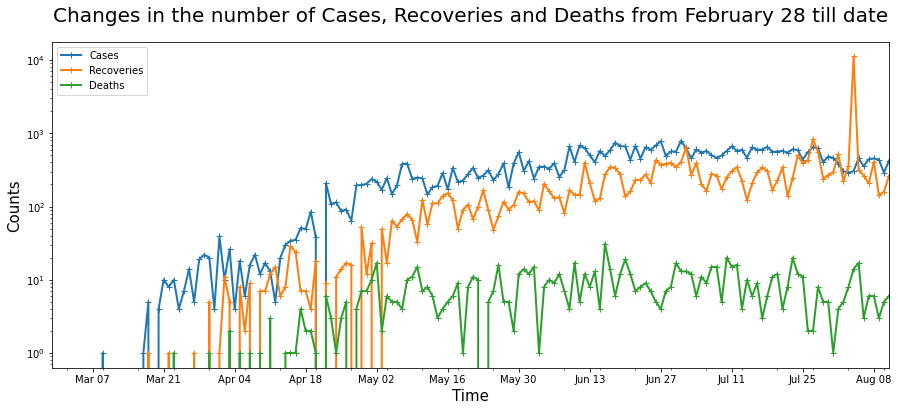

In [57]:
fig, ax = plt.subplots(figsize=(15, 6))
time_series.diff().plot(ax=ax, linewidth=2, marker='+')
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])
ax.legend(loc='upper left')
ax.set_yscale('log')
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png', dpi=150)